##Essential Information Enhanced Fact-Checking on SciFact dataset.

In this assignment we are going to perform the Essential Information Enhanced Fact-Checking task over the SciFact dataset, using various binary classification transformer models and Evaluate the insertion of the \<hl\> tags on this binary classification task. The SciFact dataset consists of 1.4K expert-written claims classified as Supported or contradicted. Our dataset consists of the following columns:

**claim:** The fact that we have to verify.

**evidence:** The list of evidences that either support or contradict the associated claim and also contain the label that represents if the evidence supports or contradicts the claim. One claim can have more than one evidence linked with it.

**id:** A number associated to each claim.

# Install Dependencies


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from torch.utils.data import Dataset, DataLoader
from google.colab import drive
import os
import requests
import torch
import zipfile
import pandas as pd
import numpy as np
import json
import random
from tqdm import tqdm
from typing import List
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import warnings
warnings.filterwarnings('ignore')
from transformers import AutoConfig, AutoTokenizer, AutoModelForSequenceClassification, get_cosine_schedule_with_warmup

# Data preparation

Data preparation

In this section we are going to simply download the SciFact dataset and store it in a local folder. I have already downloaded the dataset from their site https://leaderboard.allenai.org/scifact/submissions/get-started and stored it in the drive. I am loading the train, validation and test dataset and evidence dataset that contains the evidences that are associated with each claim.

In [ ]:
#@title Load data from drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
scifactDataTrain = pd.read_json('/content/drive/MyDrive/Datasets/sciFact/data/claims_train.jsonl', lines=True)
scifactDataVal = pd.read_json('/content/drive/MyDrive/Datasets/sciFact/data/claims_dev.jsonl', lines=True)
scifactDataTest = pd.read_json('/content/drive/MyDrive/Datasets/sciFact/data/claims_test.jsonl', lines=True)
sciFactEvidence = pd.read_json('/content/drive/MyDrive/Datasets/sciFact/data/corpus.jsonl', lines=True)

In [ ]:
print("The size of Train set is " + str(scifactDataTrain.shape[0]))
print("The size of Validation set is " + str(scifactDataVal.shape[0]))
print("The size of Test set is " + str(scifactDataTest.shape[0]))
random_state=42
random.seed(random_state)
np.random.seed(random_state)

The size of Train set is 809
The size of Validation set is 300
The size of Test set is 300


In [ ]:
scifactDataTrain.head()

,id,claim,evidence,cited_doc_ids
0,0,0-dimensional biomaterials lack inductive prop...,{},[31715818]
1,2,1 in 5 million in UK have abnormal PrP positiv...,"{'13734012': [{'sentences': [4], 'label': 'CON...",[13734012]
2,4,1-1% of colorectal cancer patients are diagnos...,{},[22942787]
3,6,10% of sudden infant death syndrome (SIDS) dea...,{},[2613775]
4,9,32% of liver transplantation programs required...,"{'44265107': [{'sentences': [15], 'label': 'SU...",[44265107]


In [ ]:
sciFactEvidence.head()

,doc_id,title,abstract,structured
0,4983,Microstructural development of human newborn c...,[Alterations of the architecture of cerebral w...,False
1,5836,Induction of myelodysplasia by myeloid-derived...,[Myelodysplastic syndromes (MDS) are age-depen...,False
2,7912,"BC1 RNA, the transcript from a master gene for...",[ID elements are short interspersed elements (...,False
3,18670,The DNA Methylome of Human Peripheral Blood Mo...,[DNA methylation plays an important role in bi...,False
4,19238,The human myelin basic protein gene is include...,[Two human Golli (for gene expressed in the ol...,False


I am removing the rows the do not contain the evidence for their claim.It is because we need evidences to train the model and empty evidence rows are of no use to us. 

In [ ]:
# Count the number of rows where evidence is empty
empty_evidence_rows = (scifactDataTrain['evidence'].values == {}).sum()
print("The number of empty evidence rows in our train set are " + str(empty_evidence_rows))

The number of empty evidence rows in our train set are 304


Drop rows with no evidence for train, validation and test set.

In [ ]:
scifactDataTrain['evidence'] = scifactDataTrain['evidence'].mask(scifactDataTrain['evidence'] == {})
scifactDataTrain.dropna(subset=['evidence'], how='all', inplace=True)
scifactDataTrain.reset_index(drop=True, inplace=True)
scifactDataVal['evidence'] = scifactDataVal['evidence'].mask(scifactDataVal['evidence'] == {})
scifactDataVal.dropna(subset=['evidence'], how='all', inplace=True)
scifactDataVal.reset_index(drop=True, inplace=True)

In [ ]:
print("The size of train dataset after dropping the empty evidences are " + str(scifactDataTrain.shape[0]))
print("The size of val dataset after dropping the empty evidences are " + str(scifactDataVal.shape[0]))

The size of train dataset after dropping the empty evidences are 505
The size of val dataset after dropping the empty evidences are 188


We can see from the above rows that the evidence column of train data only contains the ids of the evidences associated with them and the sentence number that support/contradict the evidence, and it doesn't contains the actual evidence text. I am below creating a new column in our dataset that contains the actual evidence text associated to each claim.

Also, I am creating an additional column called label_evidence that contains the labels of support/contradict that are associated with the claim.

In [ ]:
#@title Code to add evidence and label columns
#Adding additional column to my model the evidence text associated to each claim.
def addEvidenceText(row: pd.Series) -> str:
    evidence_id = list(row['evidence'].keys())[0]
    abstract = sciFactEvidence.loc[sciFactEvidence['doc_id'] == int(evidence_id)]
    return abstract['abstract'].values[0]

def addLabelEvidence(row: pd.Series) -> str:
   label_evidence = row['evidence']
   for doc_id, evidence_sets in label_evidence.items():
      return evidence_sets[0]['label']
      
#Adding function to convert list of evidence into string
def list_to_string(lst):
    listToStr = " ".join(lst)
    return str(listToStr)

#Adding function to put rationale in the <hl> tags
def setTagInEvidence(row: pd.Series) -> str:
 # id =list(row['evidence'].keys())[0]
  label_evidence = list(row['evidence'].values())[0]
  evidence = row['evidence_text']
  for evidenceList in label_evidence:
      rationaleSentenceList = evidenceList['sentences']
      for value in rationaleSentenceList:
          evidence[value] = tag_start + evidence[value] + tag_end
  return evidence

I am splitting my train dataset into train and test because I don't have evidences given in the test dataset so I am keeping some of the train data for the test.

In [ ]:
#Splitting the train into train and val.
train_set, test_set = train_test_split(scifactDataTrain,test_size=0.2,random_state=random_state,shuffle=True)
print("The size of train dataset is " + str(train_set.shape[0]))
print("The size of test dataset is " + str(test_set.shape[0]))
print("The size of vaidation dataset is " + str(scifactDataVal.shape[0]))

The size of train dataset is 404
The size of test dataset is 101
The size of vaidation dataset is 188


Apply function to add the evidence column in both the train and the validation data.

In [ ]:
train_set['evidence_text'] = train_set.apply(addEvidenceText, axis=1)
scifactDataVal['evidence_text'] = scifactDataVal.apply(addEvidenceText, axis=1)
test_set['evidence_text'] = test_set.apply(addEvidenceText, axis=1)

Apply function to create new column with label evidence.

In [ ]:
#Apply function to create new column with label evidence
train_set['label_evidence'] = train_set.apply(addLabelEvidence, axis=1)
scifactDataVal['label_evidence'] = scifactDataVal.apply(addLabelEvidence, axis=1)
test_set['label_evidence'] = test_set.apply(addLabelEvidence, axis=1)
 

In [ ]:
train_set.head()

,id,claim,evidence,cited_doc_ids,evidence_text,label_evidence
75,222,Ca2+ cycling is a UCP1-independent thermogenic...,"{'19205437': [{'sentences': [1], 'label': 'SUP...",[19205437],[Uncoupling protein 1 (UCP1) plays a central r...,SUPPORT
442,1231,The minor G allele of FOXO3 is related to less...,"{'13905670': [{'sentences': [3], 'label': 'SUP...",[13905670],"[The clinical course and eventual outcome, or ...",SUPPORT
15,55,AMP-activated protein kinase (AMPK) activation...,"{'49556906': [{'sentences': [5], 'label': 'SUP...",[49556906],[Fibrosis is a pathological result of a dysfun...,SUPPORT
325,928,Patients with microcytosis and higher erythroc...,"{'18174210': [{'sentences': [2], 'label': 'CON...",[18174210],[BACKGROUND The heritable haemoglobinopathy al...,CONTRADICT
388,1084,Side effects associated with antidepressants i...,"{'5691302': [{'sentences': [10], 'label': 'SUP...",[5691302],[OBJECTIVES To investigate the association bet...,SUPPORT


We can see above that the new columns of evidence_text and label_evidence are created and they contain the relevant information associated with each calim.

Removing some of the data from the validation datset and adding it to the train dataset so we will have more data to train.

In [ ]:
#RUN THIS CELL ONLY ONCE
#Adding 80 more rows from val data set to the train set.
rows_to_remove = range(0,81)

# Append the rows to train dataset
train_set = train_set.append(scifactDataVal.loc[rows_to_remove])

# Remove the appended rows from scifactDataVal/val dataset
scifactDataVal = scifactDataVal.drop(rows_to_remove)

In [ ]:
print("The size of train dataset is " + str(train_set.shape[0]))
print("The size of test dataset is " + str(test_set.shape[0]))
print("The size of val dataset is " + str(scifactDataVal.shape[0]))

The size of train dataset is 485
The size of test dataset is 101
The size of val dataset is 107


In [ ]:
train_set = train_set.reset_index(drop=True)
test_set = test_set.reset_index(drop=True)
scifactDataVal = scifactDataVal.reset_index(drop=True)

In [ ]:
train_set.head()

,id,claim,evidence,cited_doc_ids,evidence_text,label_evidence
0,222,Ca2+ cycling is a UCP1-independent thermogenic...,"{'19205437': [{'sentences': [1], 'label': 'SUP...",[19205437],[Uncoupling protein 1 (UCP1) plays a central r...,SUPPORT
1,1231,The minor G allele of FOXO3 is related to less...,"{'13905670': [{'sentences': [3], 'label': 'SUP...",[13905670],"[The clinical course and eventual outcome, or ...",SUPPORT
2,55,AMP-activated protein kinase (AMPK) activation...,"{'49556906': [{'sentences': [5], 'label': 'SUP...",[49556906],[Fibrosis is a pathological result of a dysfun...,SUPPORT
3,928,Patients with microcytosis and higher erythroc...,"{'18174210': [{'sentences': [2], 'label': 'CON...",[18174210],[BACKGROUND The heritable haemoglobinopathy al...,CONTRADICT
4,1084,Side effects associated with antidepressants i...,"{'5691302': [{'sentences': [10], 'label': 'SUP...",[5691302],[OBJECTIVES To investigate the association bet...,SUPPORT


WRITING CODE TO PUT THE <hl> TAGS IN THE RATIONALE.

Below is the code that further pre-processes our dataset. Since, I am asked to put the tags in the evidence text sentences that actually supports/contradicts the claim. Below is the code to add the tags in the evidence column only in the train set.

In [ ]:
set_tags_in_evidence = False #set this to true if you want to put h tags in the evidence set at the start and end of rationale.
tag_start = '<hl>'
tag_end = '<\hl>'

if(set_tags_in_evidence == True):
    train_set['evidence_text'] = train_set.apply(setTagInEvidence, axis=1)
    

COVERTING THE EVIDENCE TEXT FROM LIST TO STRING BECAUSE THE MODEL ENCODE TAKES THE  STRINGS AS INPUT

In [ ]:
train_set["evidence_text"] = train_set["evidence_text"].apply(list_to_string)
scifactDataVal["evidence_text"] = scifactDataVal["evidence_text"].apply(list_to_string)
test_set["evidence_text"] = test_set["evidence_text"].apply(list_to_string)

In [ ]:
#checking the unique values of the label_evidence column
train_set["label_evidence"].unique()

array(['SUPPORT', 'CONTRADICT'], dtype=object)

# Model Definition and Training

Initialising the arguments for the model and loading the model. I am using 4 base models to train the data which are:


*   RoBERTa.
*   BERT.
*   BART.
*   SciBERT.

Each model is run two times. One for the usual SciFact dataset and other for the SciFact dataset with \<h\> tags in the evidence sentences that support/contradict the claim.

We do this because we want to see the difference that the insertion of \<h\> tags do on our classification task and we want to compare the models.

I am considering the following metrics:
   * Accuracy 
   * Precision 
   * Recall 
   * F1-Score
   * Macro-F1



In [ ]:
args = {
    #'model_name' : 'roberta-large',
    #'model_name' : 'bert-base-uncased',
    'model_name' : 'facebook/bart-base',
    #'model_name' : 'allenai/scibert_scivocab_uncased',
    'lr_base' : 1e-5,
    'lr-linear' : 1e-4,
    'batch_size' : 4,
    'epochs' : 10,
    'batch_size_accumulated' : 256, #The batch size for each gradient update.
}

In the cell below, I am initialising the tokenizer and the model. When the set_tags_in_evidence variable is set to True, it means there are \<h\> tags in our dataset and the model is asked learn these additional tags/tokens.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device "{device}"')
tokenizer = AutoTokenizer.from_pretrained(args['model_name'])
if(set_tags_in_evidence == True):
  special_tokens_dict = ['<hl>', '<\hl>','<\\hl>']
  num_added_toks = tokenizer.add_tokens(special_tokens_dict)
config = AutoConfig.from_pretrained(args['model_name'], num_labels=2)
model = AutoModelForSequenceClassification.from_pretrained(args['model_name'], config=config).to(device)
if(set_tags_in_evidence == True):
  model.resize_token_embeddings(len(tokenizer))


if(args['model_name'] == 'roberta-large'):
# If you are using non-roberta based models, change this to point to the right base
  params= [{'params': model.roberta.parameters(), 'lr': args['lr_base']},
  {'params': model.classifier.parameters(), 'lr': args['lr-linear']}]
else:
  params = [{'params': model.parameters(), 'lr': args['lr_base']},]

optimizer = torch.optim.Adam(
    params
)
scheduler = get_cosine_schedule_with_warmup(optimizer, 0, 20)

Using device "cuda"


Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight', 'classification_head.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#Tokenize and prepare for the model a list of sequences or a list of pairs of sequences.
# Returns input_ids -- List of token ids to be fed to a model, token_type_ids and attention_mask.
def encode(claims: List[str], evidence_text: List[str]):
    encoded_dict = tokenizer.batch_encode_plus(
        list(zip(evidence_text, claims)),
        max_length = 512,
        padding=True,
        return_tensors='pt',
        add_special_tokens = True,
        truncation_strategy='only_first',     
        )
    encoded_dict = {key: tensor.to(device) for key, tensor in encoded_dict.items()}
    return encoded_dict

Writing function to evaluate the model on the basis of the following scores.
* Accuracy 
* Precision 
* Recall 
* F1-Score 
* F1-Score 
* Macro-F1


In [ ]:
def evaluate(model, dataset):
    targets = []
    outputs = []
    with torch.no_grad():
        for batch in DataLoader(dataset, batch_size=args['batch_size']):
            encoded_dict = encode(batch['claim'], batch['evidence_text'])
            logits = model(**encoded_dict)[0]
            targets.extend(batch['label_evidence'].float().tolist())
            outputs.extend(logits.argmax(dim=1).tolist())
    return {
        'macro_f1': f1_score(targets, outputs, zero_division=0, average='macro'),
        'f1': f1_score(targets, outputs),
        'precision': precision_score(targets, outputs),
        'recall': recall_score(targets, outputs),
        'accuracy' : accuracy_score(targets, outputs)
    }

Creating a custom DataLoader class to load the data.

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.samples = []
        label_encodings = {'CONTRADICT': 0, 'SUPPORT': 1}
        for index, row in self.dataframe.iterrows():
          self.samples.append({
                          'claim': row['claim'],
                          'evidence_text' : row["evidence_text"],
                          'label_evidence': label_encodings[row['label_evidence']]
                      })

    def __len__(self):
         return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]
          

TRAIN AND EVALUATE THE MODEL

In [ ]:
train_dataset = CustomDataset(train_set)
Val_dataset = CustomDataset(scifactDataVal)
test_dataset = CustomDataset(test_set)

In [ ]:
torch.cuda.empty_cache()
for e in range(args['epochs']):
      model.train()
      t = tqdm(DataLoader(train_dataset, batch_size=args['batch_size'], shuffle=False))
      for i, batch in enumerate(t):
        encoded_dict = encode(batch['claim'], batch['evidence_text'])
        output = model(**encoded_dict, labels=batch['label_evidence'].long().to(device))
        loss = output.loss
        logits = output.logits
        loss.backward()
        if (i + 1) % (args['batch_size_accumulated'] // args['batch_size']) == 0:
            optimizer.step()
            optimizer.zero_grad()
            t.set_description(f'Epoch {e}, iter {i}, loss: {round(loss.item(), 4)}')
      scheduler.step()
# Eval
train_score = evaluate(model, train_dataset)
print('Train score:')
print(train_score)
dev_score = evaluate(model, Val_dataset)
print('Dev score:')
print(dev_score)
test_score = evaluate(model, test_dataset)
print('Test score:')
print(test_score)

# Save the model
save_path = os.path.join("/content/drive/MyDrive/MOdels", f'withHtagsBART')
os.makedirs(save_path)
tokenizer.save_pretrained(save_path)
model.save_pretrained(save_path)

Epoch 9, iter 63, loss: 0.7666: 100%|██████████| 122/122 [00:50<00:00,  2.43it/s]


Train score:
{'macro_f1': 0.5732466306120697, 'f1': 0.7677053824362606, 'precision': 0.7020725388601037, 'recall': 0.846875, 'accuracy': 0.6618556701030928}
Dev score:
{'macro_f1': 0.5070181077895638, 'f1': 0.718954248366013, 'precision': 0.6395348837209303, 'recall': 0.8208955223880597, 'accuracy': 0.5981308411214953}
Test score:
{'macro_f1': 0.5799902152641879, 'f1': 0.767123287671233, 'precision': 0.7272727272727273, 'recall': 0.8115942028985508, 'accuracy': 0.6633663366336634}


# Problem Statement

Our Problem is the classification problem. We are given the claim and the evidence and we have to check if the given evidence supports or contradicts our claim. The output of the model is either SUPPORTS or REFUTES. That means our evidence will either support the claim or it will contradict the claim. Below is the given example of our dataset.

In [ ]:
train_set.iloc[10]

In [ ]:
train_set.iloc[10].claim

'TNFAIP3 is a glioblastoma tumor suppressor.'

The above cell shows one of the claims that we have to verify.

In [ ]:
train_set.iloc[10].evidence_text

'Glioblastomas are deadly cancers that display a functional cellular hierarchy maintained by self-renewing glioblastoma stem cells (GSCs). GSCs are regulated by molecular pathways distinct from the bulk tumor that may be useful therapeutic targets. We determined that A20 (TNFAIP3), a regulator of cell survival and the NF-kappaB pathway, is overexpressed in GSCs relative to non-stem glioblastoma cells at both the mRNA and protein levels. To determine the functional significance of A20 in GSCs, we targeted A20 expression with lentiviral-mediated delivery of short hairpin RNA (shRNA). Inhibiting A20 expression decreased GSC growth and survival through mechanisms associated with decreased cell-cycle progression and decreased phosphorylation of p65/RelA. Elevated levels of A20 in GSCs contributed to apoptotic resistance: GSCs were less susceptible to TNFalpha-induced cell death than matched non-stem glioma cells, but A20 knockdown sensitized GSCs to TNFalpha-mediated apoptosis. The decrease

The above cell contains the evidence of the claim and this evidence will either contradict or support the above mentioned claim.

In [ ]:
train_set.iloc[10].evidence

{'33370': [{'sentences': [4], 'label': 'CONTRADICT'},
  {'sentences': [9], 'label': 'CONTRADICT'}]}

The above column of evidence contains the sentence numbers of evidence_text that actually contradicts the claim. These sentences are tagged by \<hl\> tags for the models which contains tags.

train_set.iloc[10].label

The label column in our dataset tells us if the claim is supported or refuted/contradicted by the evidence. We see above that the label column tells that the evidence CONTRADICT the claim.

The above four cells define our problem statement and the dataset.

Our task is to create the classification model for the above problem and then add the \<hl\> tags to the sentences that actually supports/contradicts the claim (in the evidence) and finally see the difference between the models. We want to check if our model has actually learned something when we add the \<hl\> tags while training or not. Below are the results of all the models for their respective test and validation set.

# Results

In total, I have trained 8 models on our dataset. 4 models for the train dataset that do not contain the \<hl\> tags and 4 models for the train dataset that contains the \<hl\> tags.

Following are the results of all the models of their respective test set scores and validation set scores. 

There are 3 columns for each dataset score. 
  
1. **The first column contains the results of test/validation score when the model  was trained without \<hl\> tags.**

2. **The second column shows the results when the model was trained with \<hl\> tags but no tags were present in the test set and the validation set during model evaluation.**


3. **The third column shows the scores of a model that was trained with the \<hl\> tags and  these tags were also present in the validation and test sets during model evaluation.**



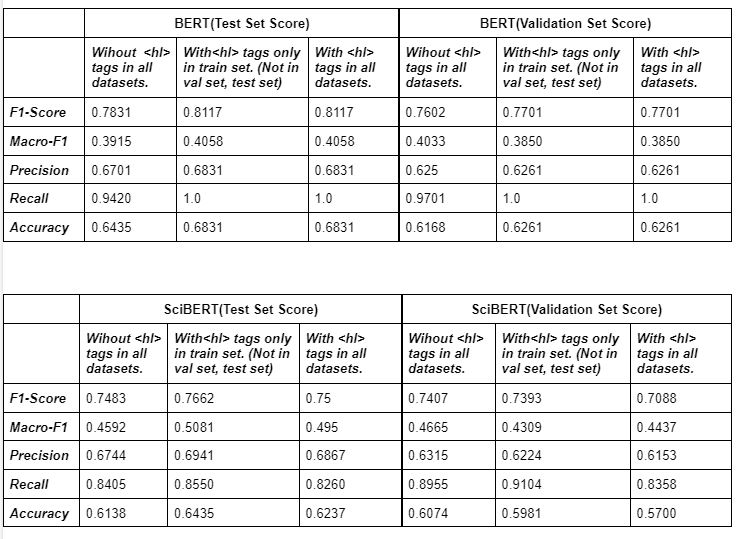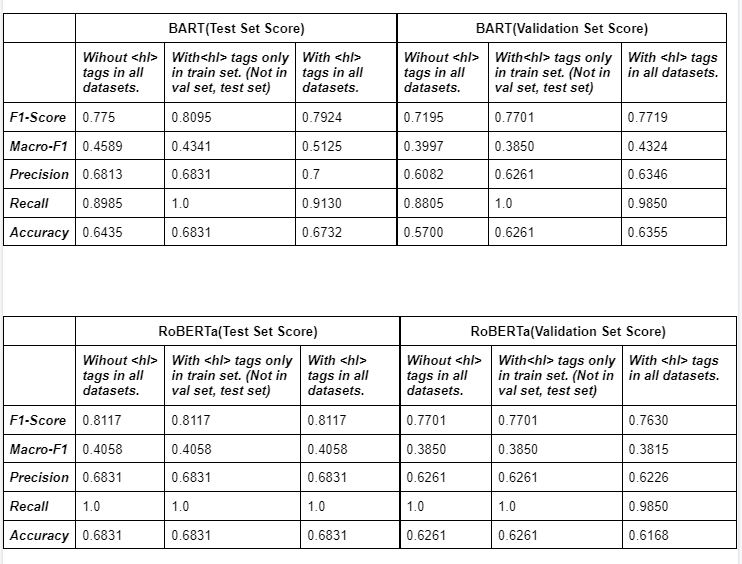

From the above results, we can see that our technique of adding the <hl> tags to the evidence sentences that support/contradict the claim is useful. for example comapring the accuracy BERT witout having <hl> tags is 64.35% while the same model have the accuracy of 68.31% when the <hl> tags are added to the evidence text while training. This means that our model is learning from the tags and when we pass the test set that doesn't contain the tags, the accuracy of the model is still increased. Hence, our technique is working.

# CODE TO LOAD THE SAVED MODEL 

CODE TO LOAD THE SAVED MODEL FROM THE DRIVE TO RECREATE THE RESULTS.

In [ ]:
newModel = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/SciFactDatasetwithHtagsBERTepoch-9-f1-7701").to(device)
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/SciFactDatasetwithHtagsBERTepoch-9-f1-7701")

In [ ]:
Val_score_new = evaluate(newModel, Val_dataset)
test_score_new = evaluate(newModel, test_dataset)
print(test_score_new)
print(Val_score_new)

{'macro_f1': 0.40588235294117647, 'f1': 0.8117647058823529, 'precision': 0.6831683168316832, 'recall': 1.0, 'accuracy': 0.6831683168316832}
{'macro_f1': 0.3850574712643678, 'f1': 0.7701149425287356, 'precision': 0.6261682242990654, 'recall': 1.0, 'accuracy': 0.6261682242990654}
